In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. Rejection Sampling

('Count', 30358, 'Accepted', 10000)


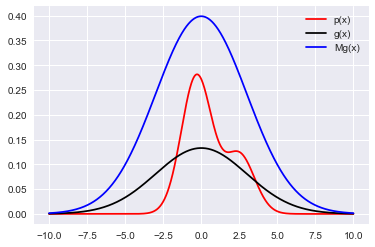

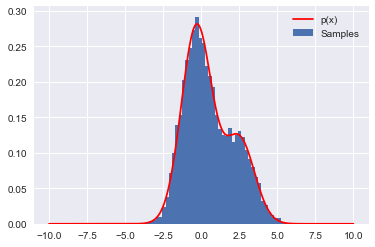

In [297]:

#p = lambda x: np.exp(-x**2/2)  # our distribution
p = lambda x: 0.7*norm.pdf(x,-0.3, 1)+0.3*norm.pdf(x,2.5, 1)
g = lambda x: norm.pdf(x,0, 3) # our proposal pdf : N(0,2^2)
#g = lambda x: 1/np.sqrt(2*pi*2**2)*np.exp(-x**2/2**2)  # our proposal pdf (we're thus choosing M to be 1)

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

M = 3

# generation loop
while (accepted < N):
    # Sample from g using inverse sampling
    xproposal = norm.rvs(0, 3, size=1)
    
    # pick a uniform number on [0, 1)
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < p(xproposal)/(M*g(xproposal)):
        samples[accepted] = xproposal
        accepted += 1
        
    count +=1
    
print("Count", count, "Accepted", accepted)

# plot the results
xmin = -10
xmax = 10

# plot target density and porposal density
plt.figure(1)
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, g(xvals), 'k', label=u'g(x)')
plt.plot(xvals, M*g(xvals), 'b', label=u'Mg(x)')
plt.legend()

# get the histogram info
hinfo = np.histogram(samples,50)

# plot the histogram
plt.figure(2)
plt.hist(samples,normed=1,bins=50, label=u'Samples');
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.legend()

# 2. Sampling-Importnace-Resampling


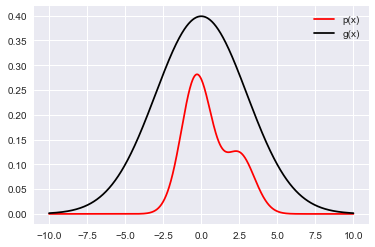

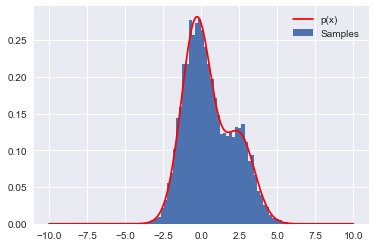

In [296]:
#p = lambda x: np.exp(-x**2/2)  # our distribution
p = lambda x: 0.7*norm.pdf(x,-0.3, 1)+0.3*norm.pdf(x,2.5, 1)
g = lambda x: 3*norm.pdf(x,0, 3) # our proposal pdf : N(0,2^2)
#g = lambda x: 1/np.sqrt(2*pi*2**2)*np.exp(-x**2/2**2)  # our proposal pdf (we're thus choosing M to be 1)

N = 100000 # the total of samples we wish to generate
n = 10000 # resample size
xproposal = norm.rvs(0, 3, size=N)
targetValue = p(xproposal)
candidateValue = g(xproposal)
ratio =  targetValue/candidateValue
importanceRatio = ratio/sum(ratio)
index = np.random.choice(N,size=n, replace=True, p=importanceRatio)
samples =xproposal[index] 

# plot the results
xmin = -10
xmax = 10

# plot target density and porposal density
plt.figure(1)
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, g(xvals), 'k', label=u'g(x)')
#plt.plot(xvals, M*g(xvals), 'b', label=u'Mg(x)')
plt.legend()

# get the histogram info
hinfo = np.histogram(samples,50)

# plot the histogram
plt.figure(2)
plt.hist(samples,normed=1,bins=50, label=u'Samples');
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.legend()

# 3. Matropolis-Hasting Algorithm

## Example 1: target density is $P(x)=0.8e^{-\frac{1}{2}\theta^2}+0.2\times\frac{1}{2}e^{-\frac{1}{2\times2^2}(\theta-3)^2}$

In [190]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples

## case 1: Single Parameter with a random-walk candidate density

The proposal density is $q(\theta,\theta')=q_1(\theta,\theta')=N(\theta';\theta,7^2)$

In [285]:
#p = lambda x: 0.8*np.exp(-x**2/2)+0.2*1/2*np.exp(-(x-3)**2/2/4) #if we use unscaled target density, it still works
p = lambda x: 0.8*norm.pdf(x,0, 1)+0.2*norm.pdf(x,3, 2)
q = lambda x_prev, x_star: norm.pdf(x_star,x_prev, 2)
qdraw = lambda x_prev:  norm.rvs(x_prev, 2, size=1) #mean is the previous sample
nsamp =10000
xinit = 1.0

samples = metropolis_hastings(p,q, qdraw, nsamp, xinit)

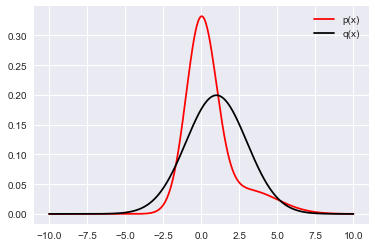

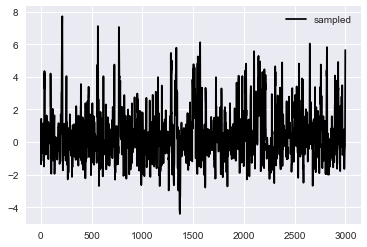

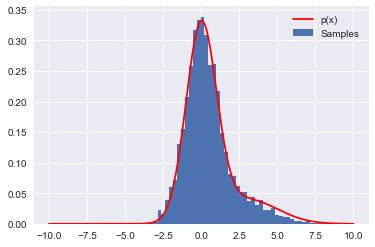

In [286]:
# plot the results
xmin = -10
xmax = 10

# plot target density and porposal density
plt.figure(1)
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, q(1,xvals), 'k', label=u'q(x)')
plt.legend()
#plt.plot(xvals, M*g(xvals), 'b', label=u'Mg(x)')

# get the histogram info
hinfo = np.histogram(samples,50)

# trace plot
plt.figure(2)

plt.plot(samples[0:3000], 'k', label='sampled')
plt.legend()


# plot the histogram
plt.figure(3)

plt.hist(samples,bins=50, normed=1, label=u'Samples');
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.legend()

## case 2: Single Parameter with an independent candidate density

The proposal density is $q(\theta,\theta')=q_2(\theta')=N(\theta';0,7^2)$

In [287]:
#p = lambda x: 0.8*np.exp(-x**2/2)+0.2*1/2*np.exp(-(x-3)**2/2/4) #if we use unscaled target density, it still works
p = lambda x: 0.8*norm.pdf(x,0, 1)+0.2*norm.pdf(x,3, 2)
q = lambda x_prev, x_star: norm.pdf(x_star,0, 7) #fixed proposal density
qdraw = lambda x_dummy:  norm.rvs(0, 7, size=1)  #fixed proposal density
nsamp =10000
xinit = 2.0

samples = metropolis_hastings(p,q, qdraw, nsamp, xinit)

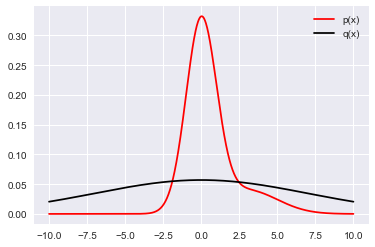

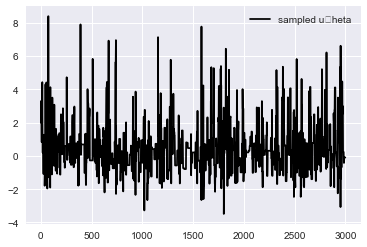

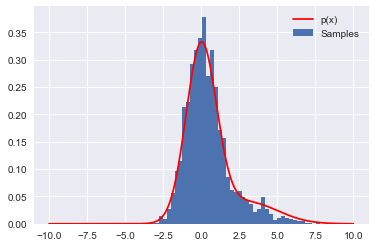

In [288]:
# plot the results
xmin = -10
xmax = 10

# plot target density and porposal density
plt.figure(1)
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, q(1,xvals), 'k', label=u'q(x)')
plt.legend()
#plt.plot(xvals, M*g(xvals), 'b', label=u'Mg(x)')

# get the histogram info
hinfo = np.histogram(samples,50)

# trace plot
plt.figure(2)

plt.plot(samples[0:3000], 'k', label='sampled u\theta')
plt.legend()


# plot the histogram
plt.figure(3)

plt.hist(samples,bins=50, normed=1, label=u'Samples');
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.legend()